## Recap

### Load original training data including PCA and FA

### Select features that will be used in GMM

### Run GMM train, pickle, load and fit

### Persist X_train

### Run feat-selection on 3 fold

In [1]:
from datetime import date, timedelta

from featureeng.times import get_trading_times_for_london_ny
from featureeng.features import *
import featureeng as feng
import data.readers as rd

import multiprocessing
import time
import threading
import json
import os

import pyarrow as pa
import pyarrow.parquet as pq

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBClassifier

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

import pickle
# Validation
from sklearn.model_selection import StratifiedKFold

root_dir = '/home/dcai/data/features'
instrument='EURCHF'
feature_set="4"



temp_save_dir="{}/{}".format(root_dir,instrument)

def save_df(save_dir, df, name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    pq.write_table(pa.Table.from_pandas(df), os.path.join(save_dir, name))


temp_save_dir="{}/{}".format(root_dir,instrument)
def read_parquet(save_dir, name):
    return pq.ParquetFile(os.path.join(save_dir, name)).read().to_pandas()


with open(os.path.join(temp_save_dir, 'y_stratified.pickle'), 'rb') as f:
    y_stratified = pickle.load(f)

In [2]:
#pre_selected_cols = ['MeanPrice_x', 'close_MIN_1D_5', 'close_MIN_1D_20', 'close_MIN_1D_60', 'close_MAX_1D_5', 'close_MAX_1D_20', 'close_MAX_1D_60', 'close_AVG_1D_5', 'close_AVG_1D_20', 'close_AVG_1D_60', 'close_STDEV_1D_5', 'close_STDEV_1D_20', 'close_STDEV_1D_60', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_20', 'close_MEDIAN_1D_60', 'close_MIN_1H_5', 'close_MIN_1H_20', 'close_MIN_1H_60', 'close_MAX_1H_5', 'close_MAX_1H_20', 'close_MAX_1H_60', 'close_AVG_1H_5', 'close_AVG_1H_20', 'close_AVG_1H_60', 'close_STDEV_1H_5', 'close_STDEV_1H_20', 'close_STDEV_1H_60', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_20', 'close_MEDIAN_1H_60', 'London', 'NY', 'rolling_1D_60_3_1', 'rolling_1D_60_3_2', 'rolling_1D_60_3_3', 'ewm_1D_60_3_1', 'ewm_1D_60_3_2', 'ewm_1D_60_3_3', 'rolling_1D_20_4_1', 'rolling_1D_20_4_2', 'rolling_1D_20_4_3', 'rolling_1D_20_4_4', 'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_1D_20_4_4', 'rolling_4H_20_4_1', 'rolling_4H_20_4_2', 'rolling_4H_20_4_3', 'rolling_4H_20_4_4', 'ewm_4H_20_4_1', 'ewm_4H_20_4_2', 'ewm_4H_20_4_3', 'ewm_4H_20_4_4', 'rolling_1D_60_20_4_1', 'rolling_1D_60_20_4_2', 'rolling_1D_60_20_4_3', 'rolling_1D_60_20_4_4', 'rolling_4H_60_20_4_1', 'rolling_4H_60_20_4_2', 'rolling_4H_60_20_4_3', 'rolling_4H_60_20_4_4', 'MeanPrice_y', 'EUR', 'CHF', 'USD', 'GBP', 'fa_0', 'fa_1', 'fa_2', 'fa_3', 'fa_4', 'fa_5', 'fa_6', 'fa_7', 'fa_8', 'fa_9', 'fa_10', 'fa_11', 'fa_12', 'fa_13', 'fa_14', 'fa_15', 'fa_16', 'fa_17', 'fa_18', 'fa_19', 'fa_20', 'fa_21', 'fa_22', 'fa_23', 'fa_24', 'fa_25', 'fa_26', 'fa_27', 'fa_28', 'fa_29', 'fa_30', 'fa_31', 'fa_32', 'fa_33', 'fa_34', 'fa_35', 'fa_36', 'fa_37', 'fa_38', 'fa_39', 'fa_40', 'fa_41', 'fa_42', 'fa_43', 'fa_44', 'fa_45', 'fa_46', 'fa_47', 'fa_48', 'fa_49', 'fa_50', 'fa_51', 'fa_52', 'fa_53', 'fa_54', 'fa_55', 'fa_56', 'fa_57', 'fa_58', 'fa_59', 'fa_60', 'fa_61', 'fa_62', 'fa_63', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56', 'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63']
X_train = read_parquet(temp_save_dir, 'X_train.parquet')#[pre_selected_cols]
Y_train = read_parquet(temp_save_dir, 'Y_train.parquet')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540376 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 228 entries, MeanPrice to pca_75
dtypes: float64(228)
memory usage: 11.2 GB


In [3]:
gmm_test_feats = ['fa_10', 'fa_11', 'fa_12']# ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']# ['fa_0', 'fa_1', 'fa_10', 'fa_11', 'fa_12']#, 'fa_13', 'fa_2', 'fa_3', 'fa_4', 'fa_5', 'fa_6', 'fa_7', 'fa_8', 'fa_9']

In [4]:
import numpy as np
import itertools
dists  = [32] #np.arange(8, 20, 4).tolist()
print(dists)


print(len([x for x in itertools.product(gmm_test_feats, dists)]))


start_time = time()
for feature, dist in itertools.product(gmm_test_feats, dists):
    
    pickle_path = os.path.join(temp_save_dir, "gmm-{}-{}.pickle".format(feature, dist))
    
    if os.path.exists(pickle_path):
        print("already done {} {}".format(feature, dist))
        #continue
    print("doing {} {}".format(feature, dist))
    
    x = X_train[[feature]][feature].values.reshape(-1, 1)
    
    gmm = GaussianMixture(n_components=dist,
                           max_iter=150,
                           random_state=0).fit(x)
    
    with open(pickle_path, 'wb') as f:
        pickle.dump(gmm, f)

        
end_time = time()
print(f'Execution time: {end_time - start_time:.3f} seconds')  

[32]
3
already done fa_10 32
doing fa_10 32
already done fa_11 32
doing fa_11 32
already done fa_12 32
doing fa_12 32
Execution time: 393.267 seconds


In [4]:
import numpy as np
import itertools
dists  = [32] #np.arange(8, 20, 4).tolist()
print(dists)

gmm_temp = os.path.join(temp_save_dir, "gmm")

start_time = time()
for feature, dist in itertools.product(gmm_test_feats, dists):
    df = pd.DataFrame()

    
    pickle_path = os.path.join(temp_save_dir, "gmm-{}-{}.pickle".format(feature, dist))
    
    if not os.path.exists(pickle_path):
        print("file missing; skip {} {}".format(feature, dist))
        continue
    print("doing {} {}".format(feature, dist))
    
    with open(pickle_path, 'rb') as f:
        gmm = pickle.load(f)

    x = X_train[[feature]][feature].values.reshape(-1, 1)
    
    clus = pd.get_dummies(gmm.predict(x)).values * x
    
    clus_feats = [f'{feature}_gmm_dev_{i}'for i in range(clus.shape[1])]
    X_train[clus_feats] = clus
    df[clus_feats] = clus
    save_df(gmm_temp, df, "gmm-{}-{}.parquet".format(feature, dist))
    
    df = None
    clus_feats = None
    clus = None
    x = None
    
    

end_time = time()
print(f'Execution time: {end_time - start_time:.3f} seconds')

[32]
doing pca_0 32
doing pca_1 32
doing pca_2 32
doing pca_3 32
doing pca_4 32
doing pca_5 32
doing pca_6 32
doing pca_7 32
doing pca_8 32
doing pca_9 32
Execution time: 170.046 seconds


In [5]:
import numpy as np
import glob
import gc

gc.collect()

gmm_temp = os.path.join(temp_save_dir, "gmm")

df = pd.DataFrame()

start_time = time()
files = glob.glob(os.path.join(gmm_temp, "gmm-pca*.parquet"))
files.sort()

for f in files:
    if f.find("-fa_"):
        print(f)
        dfx = pq.ParquetFile(f).read().to_pandas()
        X_train[dfx.columns.values] = dfx.values
        dfx = None
    

end_time = time()
print(X_train.info())
print(f'Execution time: {end_time - start_time:.3f} seconds')



/home/dcai/data/features/EURCHF/gmm/gmm-pca_0-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_1-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_10-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_11-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_2-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_3-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_4-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_5-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_6-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_7-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_8-32.parquet
/home/dcai/data/features/EURCHF/gmm/gmm-pca_9-32.parquet
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13080775 entries, 2018-04-16 07:00:00.668000 to 2021-10-19 20:59:55.784000
Columns: 448 entries, MeanPrice_x to pca_11_gmm_dev_29
dtypes: float64(442), int64(6)
memory usage: 43.8 GB
None
Execution time: 691.753 seconds


In [6]:
print(X_train.info())
print(X_train.columns.values)
print(len(X_train.columns.values))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540376 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 228 entries, MeanPrice to pca_75
dtypes: float64(228)
memory usage: 11.2 GB
None
['MeanPrice' 'close_MIN_1D_5' 'close_MIN_1D_20' 'close_MIN_1D_60'
 'close_MAX_1D_5' 'close_MAX_1D_20' 'close_MAX_1D_60' 'close_AVG_1D_5'
 'close_AVG_1D_20' 'close_AVG_1D_60' 'close_STDEV_1D_5'
 'close_STDEV_1D_20' 'close_STDEV_1D_60' 'close_MEDIAN_1D_5'
 'close_MEDIAN_1D_20' 'close_MEDIAN_1D_60' 'close_MIN_1H_5'
 'close_MIN_1H_20' 'close_MIN_1H_60' 'close_MAX_1H_5' 'close_MAX_1H_20'
 'close_MAX_1H_60' 'close_AVG_1H_5' 'close_AVG_1H_20' 'close_AVG_1H_60'
 'close_STDEV_1H_5' 'close_STDEV_1H_20' 'close_STDEV_1H_60'
 'close_MEDIAN_1H_5' 'close_MEDIAN_1H_20' 'close_MEDIAN_1H_60'
 'close_MIN_15Min_5' 'close_MIN_15Min_20' 'close_MIN_15Min_60'
 'close_MAX_15Min_5' 'close_MAX_15Min_20' 'close_MAX_15Min_60'
 'close_AVG_15Min_5' 'close_AVG_15Min_20' 'close_AVG_15Min_60'
 'close_STDEV

In [13]:
keep_cols = ['MeanPrice_x_gmm_dev_13', 'MeanPrice_x_gmm_dev_5', 'MeanPrice_x_gmm_dev_7', 'close_AVG_1H_60_gmm_dev_0', 'close_AVG_1H_60_gmm_dev_10', 'close_AVG_1H_60_gmm_dev_15', 'close_AVG_1H_60_gmm_dev_23', 'close_MAX_1D_60_gmm_dev_15', 'close_MAX_1D_60_gmm_dev_16', 'close_MAX_1D_60_gmm_dev_20', 'close_MAX_1D_60_gmm_dev_27', 'close_MAX_1D_60_gmm_dev_29', 'close_MIN_1H_60_gmm_dev_5', 'close_STDEV_1D_60_gmm_dev_2', 'close_STDEV_1D_60_gmm_dev_3']
cols_to_drop = X_train.filter(regex='_gmm_').columns.difference(keep_cols)

print(cols_to_drop)

Index(['MeanPrice_x_gmm_dev_0', 'MeanPrice_x_gmm_dev_1',
       'MeanPrice_x_gmm_dev_10', 'MeanPrice_x_gmm_dev_11',
       'MeanPrice_x_gmm_dev_12', 'MeanPrice_x_gmm_dev_14',
       'MeanPrice_x_gmm_dev_15', 'MeanPrice_x_gmm_dev_16',
       'MeanPrice_x_gmm_dev_17', 'MeanPrice_x_gmm_dev_18',
       'MeanPrice_x_gmm_dev_19', 'MeanPrice_x_gmm_dev_2',
       'MeanPrice_x_gmm_dev_20', 'MeanPrice_x_gmm_dev_21',
       'MeanPrice_x_gmm_dev_22', 'MeanPrice_x_gmm_dev_23',
       'MeanPrice_x_gmm_dev_24', 'MeanPrice_x_gmm_dev_25',
       'MeanPrice_x_gmm_dev_26', 'MeanPrice_x_gmm_dev_27',
       'MeanPrice_x_gmm_dev_28', 'MeanPrice_x_gmm_dev_29',
       'MeanPrice_x_gmm_dev_3', 'MeanPrice_x_gmm_dev_30',
       'MeanPrice_x_gmm_dev_31', 'MeanPrice_x_gmm_dev_4',
       'MeanPrice_x_gmm_dev_6', 'MeanPrice_x_gmm_dev_8',
       'MeanPrice_x_gmm_dev_9', 'close_AVG_1H_60_gmm_dev_1',
       'close_AVG_1H_60_gmm_dev_11', 'close_AVG_1H_60_gmm_dev_12',
       'close_AVG_1H_60_gmm_dev_13', 'close_AVG_1H_60

In [14]:
X_train = X_train.drop(cols_to_drop, axis=1)


In [15]:
save_df(temp_save_dir, X_train, 'X_train.parquet')

In [3]:
from xgboost.sklearn import XGBClassifier
#initial model
store = {}


    
param = {'objective': 'multi:softprob', # Specify multiclass classification
         'num_class': 3, # Number of possible output classes
         'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
         'enable_categorical': False,
         'eval_metric': 'auc',
         #'eval_metric': ['mlogloss','merror'],

         'evals_result': store,
         'verbose_eval': 100
         }



every_nth = 25
X_train_1 = X_train[::every_nth]
Y_train_1 = Y_train[::every_nth]
y_stratified_1 = y_stratified[::every_nth]



folds = 5
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

selected_columns = list()

print(X_train_1.info())
    
for k, (train_idx, val_idx) in enumerate(skf.split(X_train_1, y_stratified_1)):
    
    print(f"FOLD {k+1}/{folds}")
    
    
    y = Y_train_1.iloc[train_idx, :].values.argmax(axis=1)

    
    xgb1 = XGBClassifier(learning_rate=0.1,
                        n_estimators=150,
                        max_depth=3,
                        min_child_weight=1,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='multi:softmax',
                        tree_method='gpu_hist',
                        num_class=3,
                        seed=27)
    
    Feature_Selector = BorutaShap(model=xgb1,
                              importance_measure='shap', 
                              classification=True)
    X = X_train_1.iloc[train_idx, :]
    print(X.info())

    Feature_Selector.fit(X=X, y=y, n_trials=50, random_state=0)
    
    #Feature_Selector.plot(which_features='all', figsize=(24,12))
    
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")
    X = None
    y = None
    
    
final_selection = sorted({item for selection in selected_columns for item in selection})

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261616 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 228 entries, MeanPrice to pca_75
dtypes: float64(228)
memory usage: 457.1 MB
None
FOLD 1/5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209292 entries, 2018-04-16 07:00:00.489000 to 2021-10-19 20:59:43.152000
Columns: 228 entries, MeanPrice to pca_75
dtypes: float64(228)
memory usage: 365.7 MB
None


  0%|          | 0/50 [00:00<?, ?it/s]

163 attributes confirmed important: ['close_MEDIAN_1H_60', 'pca_64', 'close_AVG_1H_60', 'pca_7', 'rolling_4H_60_20_4_4', 'pca_2', 'pca_69', 'rolling_4H_20_4_3', 'rolling_4H_20_4_1', 'fa_12', 'pca_24', 'close_STDEV_15Min_20', 'pca_44', 'close_MIN_1H_5', 'pca_40', 'close_AVG_15Min_20', 'close_MIN_1D_20', 'pca_30', 'pca_29', 'fa_18', 'pca_16', 'ewm_4H_20_4_4', 'pca_32', 'pca_4', 'pca_13', 'pca_34', 'pca_35', 'close_MAX_1H_20', 'close_AVG_15Min_60', 'fa_15', 'close_MEDIAN_1H_5', 'pca_53', 'close_STDEV_1D_5', 'pca_10', 'pca_19', 'pca_5', 'pca_60', 'close_MIN_15Min_5', 'close_AVG_1H_5', 'pca_54', 'rolling_1D_60_3_3', 'pca_0', 'pca_20', 'pca_52', 'fa_14', 'pca_1', 'fa_20', 'close_MEDIAN_15Min_20', 'ewm_4H_20_4_3', 'fa_17', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_STDEV_1H_20', 'rolling_1D_20_4_1', 'pca_23', 'pca_43', 'close_AVG_15Min_5', 'ewm_1D_60_3_2', 'pca_65', 'close_MIN_1D_60', 'close_AVG_1H_20', 'pca_66', 'fa_9', 'pca_63', 'pca_68', 'close_MIN_1H_20', 'pca_61', 'pca_45', 'pca_

  0%|          | 0/50 [00:00<?, ?it/s]

159 attributes confirmed important: ['close_MEDIAN_1H_60', 'pca_64', 'close_AVG_1H_60', 'pca_7', 'rolling_4H_60_20_4_4', 'pca_2', 'pca_69', 'rolling_4H_20_4_3', 'rolling_4H_20_4_1', 'fa_12', 'pca_24', 'close_STDEV_15Min_20', 'pca_44', 'close_MIN_1H_5', 'pca_40', 'close_AVG_15Min_20', 'close_MIN_1D_20', 'pca_30', 'pca_29', 'fa_18', 'pca_16', 'ewm_4H_20_4_4', 'pca_32', 'pca_4', 'pca_13', 'pca_34', 'pca_35', 'close_MAX_1H_20', 'close_AVG_15Min_60', 'fa_15', 'close_MEDIAN_1H_5', 'pca_53', 'close_STDEV_1D_5', 'pca_10', 'pca_19', 'pca_5', 'pca_60', 'close_MIN_15Min_5', 'close_AVG_1H_5', 'pca_54', 'rolling_1D_60_3_3', 'pca_0', 'pca_20', 'pca_52', 'fa_14', 'pca_1', 'fa_20', 'close_MEDIAN_15Min_20', 'ewm_4H_20_4_3', 'fa_17', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_STDEV_1H_20', 'rolling_1D_20_4_1', 'pca_23', 'pca_43', 'close_AVG_15Min_5', 'ewm_1D_60_3_2', 'pca_65', 'close_MIN_1D_60', 'close_AVG_1H_20', 'pca_66', 'fa_9', 'pca_63', 'pca_68', 'close_MIN_1H_20', 'pca_61', 'pca_45', 'pca_

  0%|          | 0/50 [00:00<?, ?it/s]

162 attributes confirmed important: ['close_MEDIAN_1H_60', 'pca_64', 'close_AVG_1H_60', 'rolling_4H_20_4_2', 'pca_7', 'rolling_4H_60_20_4_4', 'pca_2', 'pca_69', 'rolling_4H_20_4_1', 'fa_12', 'pca_24', 'close_STDEV_15Min_20', 'pca_44', 'close_MIN_1H_5', 'pca_40', 'close_AVG_15Min_20', 'close_MIN_1D_20', 'pca_30', 'pca_29', 'fa_18', 'pca_16', 'ewm_4H_20_4_4', 'pca_32', 'pca_4', 'pca_13', 'pca_34', 'pca_35', 'close_MAX_1H_20', 'close_AVG_15Min_60', 'fa_15', 'close_MEDIAN_1H_5', 'pca_53', 'close_STDEV_1D_5', 'pca_10', 'pca_19', 'pca_5', 'pca_60', 'close_MIN_15Min_5', 'close_AVG_1H_5', 'pca_54', 'pca_0', 'pca_20', 'pca_52', 'fa_14', 'pca_1', 'fa_20', 'close_MEDIAN_15Min_20', 'fa_17', 'ewm_4H_20_4_3', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_STDEV_1H_20', 'rolling_1D_20_4_1', 'pca_23', 'pca_43', 'ewm_1D_60_3_2', 'close_AVG_15Min_5', 'pca_65', 'close_MIN_1D_60', 'close_AVG_1H_20', 'pca_66', 'fa_9', 'pca_63', 'pca_68', 'close_MIN_1H_20', 'pca_61', 'pca_45', 'pca_8', 'fa_4', 'close_ME

  0%|          | 0/50 [00:00<?, ?it/s]

164 attributes confirmed important: ['close_MEDIAN_1H_60', 'pca_64', 'close_AVG_1H_60', 'pca_7', 'rolling_4H_60_20_4_4', 'pca_2', 'pca_69', 'rolling_4H_20_4_3', 'rolling_4H_20_4_1', 'fa_12', 'pca_24', 'close_STDEV_15Min_20', 'close_MIN_1H_5', 'pca_44', 'pca_40', 'close_AVG_15Min_20', 'close_MIN_1D_20', 'pca_30', 'pca_29', 'fa_18', 'pca_16', 'ewm_4H_20_4_4', 'pca_32', 'pca_4', 'pca_13', 'pca_34', 'pca_35', 'close_MAX_1H_20', 'close_AVG_15Min_60', 'fa_15', 'close_MEDIAN_1H_5', 'pca_53', 'close_STDEV_1D_5', 'pca_10', 'pca_19', 'pca_5', 'pca_60', 'close_MIN_15Min_5', 'close_AVG_1H_5', 'pca_54', 'rolling_1D_60_3_3', 'pca_0', 'pca_20', 'pca_52', 'fa_14', 'pca_1', 'fa_20', 'close_MEDIAN_15Min_20', 'ewm_4H_20_4_3', 'fa_17', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_STDEV_1H_20', 'rolling_1D_20_4_1', 'pca_23', 'pca_43', 'close_AVG_15Min_5', 'ewm_1D_60_3_2', 'pca_65', 'close_MIN_1D_60', 'close_AVG_1H_20', 'pca_66', 'fa_9', 'pca_63', 'pca_68', 'close_MIN_1H_20', 'pca_61', 'pca_72', 'pca_

  0%|          | 0/50 [00:00<?, ?it/s]

164 attributes confirmed important: ['close_MEDIAN_1H_60', 'pca_64', 'close_AVG_1H_60', 'rolling_4H_20_4_2', 'pca_7', 'rolling_4H_60_20_4_4', 'pca_2', 'pca_69', 'rolling_4H_20_4_3', 'rolling_4H_20_4_1', 'fa_12', 'pca_24', 'close_STDEV_15Min_20', 'pca_44', 'close_MIN_1H_5', 'pca_40', 'close_AVG_15Min_20', 'close_MIN_1D_20', 'pca_30', 'pca_29', 'fa_18', 'pca_16', 'ewm_4H_20_4_4', 'pca_32', 'pca_4', 'pca_13', 'pca_34', 'pca_35', 'close_MAX_1H_20', 'close_AVG_15Min_60', 'fa_15', 'close_MEDIAN_1H_5', 'pca_53', 'close_STDEV_1D_5', 'pca_10', 'pca_19', 'pca_5', 'pca_60', 'close_MIN_15Min_5', 'close_AVG_1H_5', 'pca_54', 'rolling_1D_60_3_3', 'pca_0', 'pca_20', 'pca_52', 'fa_14', 'pca_1', 'fa_20', 'fa_17', 'ewm_4H_20_4_3', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_STDEV_1H_20', 'pca_23', 'pca_43', 'rolling_1D_20_4_1', 'ewm_1D_60_3_2', 'close_AVG_15Min_5', 'pca_65', 'rolling_1D_20_4_4', 'close_MIN_1D_60', 'close_AVG_1H_20', 'pca_66', 'fa_9', 'pca_63', 'pca_68', 'close_MIN_1H_20', 'pca_61'

In [5]:
print(final_selection)
print(len(final_selection))



['MeanPrice', 'close_AVG_15Min_20', 'close_AVG_15Min_5', 'close_AVG_15Min_60', 'close_AVG_1D_20', 'close_AVG_1D_5', 'close_AVG_1D_60', 'close_AVG_1H_20', 'close_AVG_1H_5', 'close_AVG_1H_60', 'close_MAX_15Min_20', 'close_MAX_15Min_5', 'close_MAX_15Min_60', 'close_MAX_1D_20', 'close_MAX_1D_5', 'close_MAX_1D_60', 'close_MAX_1H_20', 'close_MAX_1H_5', 'close_MAX_1H_60', 'close_MEDIAN_15Min_20', 'close_MEDIAN_15Min_5', 'close_MEDIAN_15Min_60', 'close_MEDIAN_1D_20', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_60', 'close_MIN_15Min_20', 'close_MIN_15Min_5', 'close_MIN_15Min_60', 'close_MIN_1D_20', 'close_MIN_1D_5', 'close_MIN_1D_60', 'close_MIN_1H_20', 'close_MIN_1H_5', 'close_MIN_1H_60', 'close_STDEV_15Min_20', 'close_STDEV_15Min_5', 'close_STDEV_15Min_60', 'close_STDEV_1D_20', 'close_STDEV_1D_5', 'close_STDEV_1D_60', 'close_STDEV_1H_20', 'close_STDEV_1H_5', 'close_STDEV_1H_60', 'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_

In [7]:
print(final_selection)
print(len(final_selection))

with open(os.path.join(temp_save_dir, 'selected_feats-6.pickle'), 'wb') as f:
    pickle.dump(final_selection, f)
    
    
    

['MeanPrice', 'close_AVG_15Min_20', 'close_AVG_15Min_5', 'close_AVG_15Min_60', 'close_AVG_1D_20', 'close_AVG_1D_5', 'close_AVG_1D_60', 'close_AVG_1H_20', 'close_AVG_1H_5', 'close_AVG_1H_60', 'close_MAX_15Min_20', 'close_MAX_15Min_5', 'close_MAX_15Min_60', 'close_MAX_1D_20', 'close_MAX_1D_5', 'close_MAX_1D_60', 'close_MAX_1H_20', 'close_MAX_1H_5', 'close_MAX_1H_60', 'close_MEDIAN_15Min_20', 'close_MEDIAN_15Min_5', 'close_MEDIAN_15Min_60', 'close_MEDIAN_1D_20', 'close_MEDIAN_1D_5', 'close_MEDIAN_1D_60', 'close_MEDIAN_1H_20', 'close_MEDIAN_1H_5', 'close_MEDIAN_1H_60', 'close_MIN_15Min_20', 'close_MIN_15Min_5', 'close_MIN_15Min_60', 'close_MIN_1D_20', 'close_MIN_1D_5', 'close_MIN_1D_60', 'close_MIN_1H_20', 'close_MIN_1H_5', 'close_MIN_1H_60', 'close_STDEV_15Min_20', 'close_STDEV_15Min_5', 'close_STDEV_15Min_60', 'close_STDEV_1D_20', 'close_STDEV_1D_5', 'close_STDEV_1D_60', 'close_STDEV_1H_20', 'close_STDEV_1H_5', 'close_STDEV_1H_60', 'ewm_1D_20_4_1', 'ewm_1D_20_4_2', 'ewm_1D_20_4_3', 'ewm_

In [7]:
X_train_2 = read_parquet(temp_save_dir, 'X_train.parquet')

<AxesSubplot:xlabel='DateTime'>

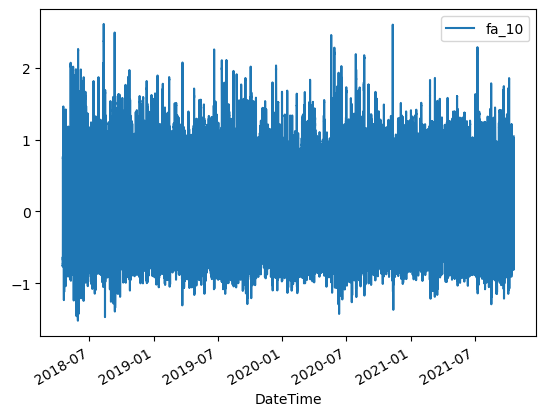

In [9]:
X_train_2[['fa_10']][::100].plot()